In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
import torch
import sys

In [34]:
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [35]:
# Extract features from augmented dataset

X_train = np.load("../models/features_train_resnet18.npy")
y_train = np.load("../models/labels_train_resnet18.npy")

X_test = np.load("../models/features_test_resnet18.npy")
y_test = np.load("../models/labels_test_resnet18.npy")


In [36]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Grid Search to find best SVM Parameters

In [37]:
# # cv for cross-validation splits
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# svm_base = SVC(probability=True)

# # Parameter grid
# param_grid = {
#     'kernel': ['rbf'],                  
#     'C': [0.1, 1, 5, 10, 30, 50, 100],    
#     'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001]  
# }

# grid = GridSearchCV(
#     estimator=svm_base,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(X_train, y_train)

# print("\n BEST VALIDATION ACCURACY:", grid.best_score_)
# print(" BEST PARAMS:", grid.best_params_)

# # Train final SVM using best parameters
# SVM_model = grid.best_estimator_
# SVM_model.fit(X_train, y_train)

# # Evaluate on test set
# y_pred = SVM_model.predict(X_test)
# print("\n Test Accuracy with Best SVM:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=CLASSES))


# SVM Model Training

In [38]:
SVM_model = SVC(kernel='rbf', C=5, gamma='auto', probability=True)
SVM_model.fit(X_train, y_train)
y_pred = SVM_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))

SVM Accuracy: 0.8826666666666667


# Best SVM Threshold Function

In [39]:
def find_best_svm_threshold(model, x_test, Y_test):
    probs = model.predict_proba(x_test)
    # Get max probability for each prediction (confidence)
    max_probs = np.max(probs, axis=1)
    # actual predicted labels
    preds = np.argmax(probs, axis=1)
    # the probabilities where the predictions were correct
    correct_labels = (preds == Y_test)
    correct_confidences = max_probs[correct_labels]
    threshold = np.percentile(correct_confidences, 10)
    # to limit threshold between 0 and 1
    return max(0.0, min(1.0, threshold))

In [40]:
svm_threshold = find_best_svm_threshold(SVM_model, X_test, y_test)
print(svm_threshold)

0.7635912970824887


# Handling the “Unknown” Class (ID 6) SVM

In [41]:
def svm_predict_with_rejection(model, x, threshold, unknown_label=6):

    probs = model.predict_proba(x)
    max_probs = np.max(probs, axis=1)       # confidence
    preds = np.argmax(probs, axis=1)        # predicted class

    # Assign Unknown where confidence is low
    final_preds = np.where(max_probs >= threshold, preds, unknown_label)

    return final_preds, max_probs


In [42]:
svm_preds_with_unknown, svm_conf = svm_predict_with_rejection(SVM_model, X_test, svm_threshold)

print(svm_preds_with_unknown[:20])  # show sample predictions


[0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0]


In [43]:
# Count unknowns
num_unknown = np.sum(svm_preds_with_unknown == 6)
print("Total Unknown Predictions:", num_unknown)

# Evaluate accuracy on NON-unknowns
is_known = (svm_preds_with_unknown != 6)
acc_accepted = accuracy_score(y_test[is_known], svm_preds_with_unknown[is_known])
print("Accuracy:", acc_accepted)


Total Unknown Predictions: 63
Accuracy: 0.9551282051282052


# Grid Search to find best KNN Parameters

In [44]:
# # Define cross-validation strategy
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# knn_base = KNeighborsClassifier()

# param_grid_knn = {
#     'n_neighbors': [3, 5, 7, 9],
#     'metric': ['euclidean', 'manhattan'],
#     'weights': ['uniform', 'distance'] 
# }

# grid_knn = GridSearchCV(
#     estimator=knn_base,
#     param_grid=param_grid_knn,
#     cv=cv,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=2
# )

# grid_knn.fit(X_train, y_train)

# print("\nBEST VALIDATION ACCURACY (KNN):", grid_knn.best_score_)
# print("BEST PARAMS (KNN):", grid_knn.best_params_)

# # Train final KNN using best parameters
# KNN_model = grid_knn.best_estimator_
# KNN_model.fit(X_train, y_train)

# # Evaluate on test set
# y_pred_knn = KNN_model.predict(X_test)
# print("\nTest Accuracy with Best KNN:", accuracy_score(y_test, y_pred_knn))
# print("\nClassification Report KNN:")
# print(classification_report(y_test, y_pred_knn, target_names=CLASSES))


# KNN Model Training

In [45]:
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='distance')
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred_knn)

print("KNN Accuracy:", acc)

KNN Accuracy: 0.8346666666666667


# Best KNN Threshold Function

In [46]:

def find_best_knn_threshold_distance(knn_model, X_val, y_val, margin=0.02):

    # Get distances to nearest neighbors
    distances, indices = knn_model.kneighbors(X_val)
    
    # Mean distance → confidence
    mean_dist = distances.mean(axis=1)
    conf_knn = 1.0 / (1.0 + mean_dist)   # bounded (0,1]
    
    # Predictions
    preds = knn_model.predict(X_val)

    # Correctly classified samples
    correct_mask = (preds == y_val)

    # If no correct predictions → fallback threshold
    if correct_mask.sum() == 0:
        return 0.2

    # Threshold = min(confidence of correct predictions) - margin
    min_correct_conf = conf_knn[correct_mask].min()
    threshold = max(0.0, min_correct_conf - margin)

    return threshold


In [47]:
knn_threshold = find_best_knn_threshold_distance(knn, X_test, y_test)
print(knn_threshold)

0.010240255475156345


# Handling the “Unknown” Class (ID 6) KNN

In [48]:
def knn_predict_with_rejection(knn_model, X, threshold, unknown_label=6):

    # Distances to neighbors
    distances, indices = knn_model.kneighbors(X)
    mean_dist = distances.mean(axis=1)

    # Confidence score
    conf = 1.0 / (1.0 + mean_dist)

    # Normal predictions
    preds = knn_model.predict(X)

    # Apply rejection rule
    final_preds = []
    for i in range(len(preds)):
        if conf[i] >= threshold:
            final_preds.append(preds[i])
        else:
            final_preds.append(unknown_label)

    return np.array(final_preds), conf


In [49]:
knn_preds_with_unknown, knn_conf = knn_predict_with_rejection(knn, X_test, knn_threshold)

print(knn_preds_with_unknown[:20])  # show sample predictions


[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]


In [50]:
# Count unknowns
num_unknown = np.sum(knn_preds_with_unknown == 6)
print("Total Unknown Predictions:", num_unknown)

# Evaluate accuracy on NON-unknowns
is_known = (knn_preds_with_unknown != 6)
acc_accepted = accuracy_score(y_test[is_known], knn_preds_with_unknown[is_known])
print("Accuracy:", acc_accepted)


Total Unknown Predictions: 0
Accuracy: 0.8346666666666667


# Architecture Comparison

In [51]:
results = []

# SVM Evaluation 
start_train = time.time()
SVM_model.fit(X_train, y_train)
svm_train_time = time.time() - start_train

start_test = time.time()
svm_preds = SVM_model.predict(X_test)
svm_test_time = time.time() - start_test

svm_acc = accuracy_score(y_test, svm_preds)

results.append({
    "Model": "SVM (RBF)",
    "Accuracy": svm_acc,
    "Train Time (s)": svm_train_time,
    "Inference Time (s)": svm_test_time,
    "Memory Efficient": "Yes"
})

# KNN Evaluation 
start_train = time.time()
knn.fit(X_train, y_train)
knn_train_time = time.time() - start_train 

start_test = time.time()
knn_preds = knn.predict(X_test)
knn_test_time = time.time() - start_test

knn_acc = accuracy_score(y_test, knn_preds)

results.append({
    "Model": "k-NN (k=3)",
    "Accuracy": knn_acc,
    "Train Time (s)": knn_train_time,
    "Inference Time (s)": knn_test_time,
    "Memory Efficient": "No"
})

df_comparison = pd.DataFrame(results)
print(df_comparison)


        Model  Accuracy  Train Time (s)  Inference Time (s) Memory Efficient
0   SVM (RBF)  0.882667       22.984235            1.338441              Yes
1  k-NN (k=3)  0.834667        0.004000            0.059513               No


# Classification Report for SVM

In [52]:

print("\nSVM Classification Report:")
print(classification_report(y_test, svm_preds, target_names=CLASSES))



SVM Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.94      0.97        50
       glass       0.84      0.91      0.88        77
       metal       0.86      0.89      0.88        63
       paper       0.88      0.99      0.93        90
     plastic       0.89      0.79      0.84        73
       trash       0.79      0.50      0.61        22

    accuracy                           0.88       375
   macro avg       0.88      0.84      0.85       375
weighted avg       0.88      0.88      0.88       375



# Classification Report for KNN

In [53]:

print("\nKNN Classification Report:")
print(classification_report(y_test, knn_preds, target_names=CLASSES))



KNN Classification Report:
              precision    recall  f1-score   support

   cardboard       0.92      0.92      0.92        50
       glass       0.79      0.84      0.82        77
       metal       0.76      0.84      0.80        63
       paper       0.93      0.90      0.92        90
     plastic       0.82      0.79      0.81        73
       trash       0.67      0.45      0.54        22

    accuracy                           0.83       375
   macro avg       0.81      0.79      0.80       375
weighted avg       0.83      0.83      0.83       375



# Test SVM Sample 

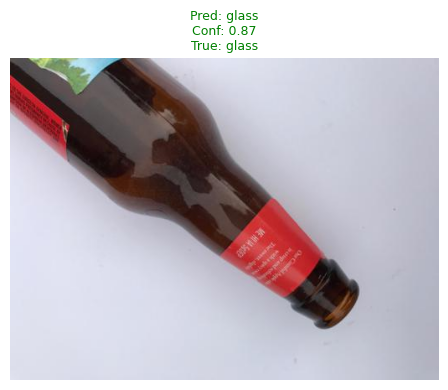

In [ ]:

# sys.path.append(os.path.abspath('../src'))
# from feature_extraction import preprocess_images, model, device

# UNKNOWN_LABEL = 6
# ALL_CLASSES = CLASSES + ['unknown']

# # Load images and extract features for visualization
# def load_and_extract_features(image_paths):
#     feats = []
#     images = []
#     for p in image_paths:
#         img = Image.open(p).convert('RGB')
#         images.append(img)
#         x = preprocess_images(img).unsqueeze(0).to(device)
#         with torch.no_grad():
#             feat = model(x).squeeze().cpu().numpy()
#         feats.append(feat)
#     return np.array(feats), images


# # Plot images with predicted and true labels
# def plot_samples(images, true_labels, pred_labels, confidences):
#     n = len(images)
#     plt.figure(figsize=(16, 4))
#     for i in range(n):
#         plt.subplot(1, n, i+1)
#         plt.imshow(images[i])
#         plt.axis('off')

#         true_cls = ALL_CLASSES[true_labels[i]]
#         pred_cls = ALL_CLASSES[pred_labels[i]]
#         conf = confidences[i]

#         title_color = 'green' if pred_labels[i] == true_labels[i] else 'red'
#         if pred_labels[i] == UNKNOWN_LABEL:
#             title = f"Pred: UNKNOWN\nConf: {conf:.2f}\nTrue: {true_cls}"
#             title_color = 'orange'
#         else:
#             title = f"Pred: {pred_cls}\nConf: {conf:.2f}\nTrue: {true_cls}"

#         plt.title(title, color=title_color, fontsize=9)
#     plt.tight_layout()
#     plt.show()

# if __name__ == '__main__':
#     # Get sample test images and labels
#     sample_path = ["D:\\Level 4 Sem 1 Assgs\\ML_Assgs\\Material-Stream-Identification-System\\dataset_split\\test\\glass\\5aade93c-3438-4b22-91bc-87e2b0334b74.jpg"]

#     sample_true_labels = [1]  # Assuming the true label for the sample is 'glass'

#     # Extract features
#     sample_feats, sample_images = load_and_extract_features(sample_path)
    
#     # Predict with rejection
#     sample_preds, sample_confs = svm_predict_with_rejection(SVM_model, sample_feats, svm_threshold)
    
#     # Plot with annotations
#     plot_samples(sample_images, sample_true_labels, sample_preds, sample_confs)

# Test KNN Sample

0.010240255475156345


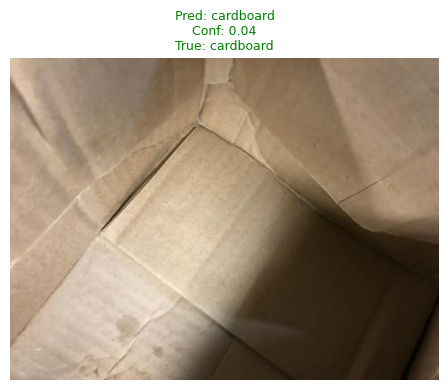

In [ ]:
# sys.path.append(os.path.abspath('../src'))
# from feature_extraction import preprocess_images, model, device

# UNKNOWN_LABEL = 6
# ALL_CLASSES = CLASSES + ['unknown']


# # Load images and extract features for visualization
# def load_and_extract_features(image_paths):
#     feats = []
#     images = []
#     for p in image_paths:
#         img = Image.open(p).convert('RGB')
#         images.append(img)
#         x = preprocess_images(img).unsqueeze(0).to(device)
#         with torch.no_grad():
#             feat = model(x).squeeze().cpu().numpy()
#         feats.append(feat)
#     return np.array(feats), images


# # Plot images with predicted and true labels
# def plot_samples(images, true_labels, pred_labels, confidences):
#     n = len(images)
#     plt.figure(figsize=(16, 4))
#     for i in range(n):
#         plt.subplot(1, n, i+1)
#         plt.imshow(images[i])
#         plt.axis('off')

#         true_cls = ALL_CLASSES[true_labels[i]]
#         pred_cls = ALL_CLASSES[pred_labels[i]]
#         conf = confidences[i]

#         title_color = 'green' if pred_labels[i] == true_labels[i] else 'red'
#         if pred_labels[i] == UNKNOWN_LABEL:
#             title = f"Pred: UNKNOWN\nConf: {conf:.2f}\nTrue: {true_cls}"
#             title_color = 'orange'
#         else:
#             title = f"Pred: {pred_cls}\nConf: {conf:.2f}\nTrue: {true_cls}"

#         plt.title(title, color=title_color, fontsize=9)
#     plt.tight_layout()
#     plt.show()

# if __name__ == '__main__':
#     sample_path = ["D:\\Level 4 Sem 1 Assgs\\ML_Assgs\\Material-Stream-Identification-System\\dataset_split\\test\\cardboard\\e609456e-4176-4518-999b-8e83e1050cbd.jpg"]
#     sample_true_labels = [0]  

#     # Extract features
#     sample_feats, sample_images = load_and_extract_features(sample_path)
#     print(knn_threshold)
    
#     # Predict with rejection
#     sample_preds, sample_confs = knn_predict_with_rejection(knn, sample_feats, knn_threshold)

#     # Plot with annotations
#     plot_samples(sample_images, sample_true_labels, sample_preds, sample_confs)
    

# Save Best Model (SVM)

In [56]:
import joblib
import json

os.makedirs("../models/deployment", exist_ok=True)

joblib.dump(SVM_model, "../models/deployment/svm_model.joblib")
joblib.dump(scaler, "../models/deployment/scaler.joblib")

with open("../models/deployment/svm_threshold.json", "w") as f:
    json.dump({"threshold": float(svm_threshold)}, f)

print("SVM deployment files saved successfully.")


SVM deployment files saved successfully.
